_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

In [2]:
#Exploring Dataset
df.head(30)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0
5,20900015,277,Stephen Curry,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,2009-10-28,GSW,HOU,Regular Season,4.0
6,20900015,413,Stephen Curry,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,2009-10-28,GSW,HOU,Regular Season,-9.0
7,20900015,453,Stephen Curry,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,2009-10-28,GSW,HOU,Regular Season,-6.0
8,20900015,487,Stephen Curry,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,2009-10-28,GSW,HOU,Regular Season,-9.0
9,20900015,490,Stephen Curry,4,1,47,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-125,134,1,2009-10-28,GSW,HOU,Regular Season,-7.0


In [3]:
##Exploring Dataset

df.columns

Index(['game_id', 'game_event_id', 'player_name', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'shot_made_flag', 'game_date', 'htm', 'vtm',
       'season_type', 'scoremargin_before_shot'],
      dtype='object')

In [4]:
# Use data time function on date. And make a new feature called year. 
df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format=True)
df['year'] = df['game_date'].dt.year


In [5]:
# Create Train Val and Test 
train = df[df['year'] < 2017]

val = df[(df['year'] == 2017) | (df['year'] == 2018)]

test = df[df['year'] == 2019]

features =['game_id', 'game_event_id', 'period',
       'minutes_remaining', 'seconds_remaining', 'action_type', 'shot_type',
       'shot_zone_basic', 'shot_zone_area', 'shot_zone_range', 'shot_distance',
       'loc_x', 'loc_y', 'htm', 'vtm', 'season_type',
       'scoremargin_before_shot', 'shot_made_flag']



In [6]:
train.shape, val.shape, test.shape

((9895, 21), (2880, 21), (1183, 21))

In [7]:
# Droping  shot_made_flag from freatures variable. 
# Seting up training and testing variables that I might need later on. 
features.remove('shot_made_flag')

target = 'shot_made_flag'

xtrain = train[features]

ytrain = train[target]

xval = val[features]

yval = val[target]

xtest = test[features]

ytest = test[target]

In [8]:
# looking up the mode for the Baseline prediction.
ytrain.value_counts()

0    5218
1    4677
Name: shot_made_flag, dtype: int64

In [9]:
# BaseLine
print('Baseline accuracy :',accuracy_score(ytrain, [0]*9895 ))

Baseline accuracy : 0.5273370389085397


In [10]:
# Making pipline with Ordinal encoding encoding 
oe_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
#    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=2000,  n_jobs=-1))

In [13]:
# Training Random Forest with ordinal encoding
%%time

# Fit on train, score on val
oe_pipeline.fit(xtrain, ytrain)

print('Validation Accuracy', oe_pipeline.score(xval, yval))
print('Baseline accuracy :',accuracy_score(ytrain, [0]*9895 ))

Validation Accuracy 0.6295138888888889
Baseline accuracy : 0.5273370389085397


In [14]:
# Making sure you have enough RAM for one hot encoding l0_0l
train.select_dtypes(exclude='number').nunique().sort_values(ascending=False)

game_date          585
action_type         50
vtm                 32
htm                 32
shot_zone_basic      7
shot_zone_area       6
shot_zone_range      5
season_type          2
shot_type            2
player_name          1
dtype: int64

In [15]:
# Making pipline with one hot encoding encoding 
ohe_pipeline = make_pipeline(
#     ce.OrdinalEncoder(),
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=2000,  n_jobs=-1))


In [17]:
# Training Random Forest with one hot encoding

%%time

# Fit on train, score on val
ohe_pipeline.fit(xtrain, ytrain)

print('Baseline accuracy :',accuracy_score(ytrain, [0]*9895 ))
print('Validation Accuracy :', ohe_pipeline.score(xval, yval))
print('Test accuracy :', ohe_pipeline.score(xtest, ytest))
      
# One hot encoding is slitly better than Ordinal encoding usualy by around .002

Baseline accuracy : 0.5273370389085397
Validation Accuracy : 0.6329861111111111
Test accuracy : 0.6246830092983939


In [18]:
# Encoding xtrain for feature importances
encoder = ce.OneHotEncoder(use_cat_names=True)

xtrain_encoded = encoder.fit_transform(xtrain)


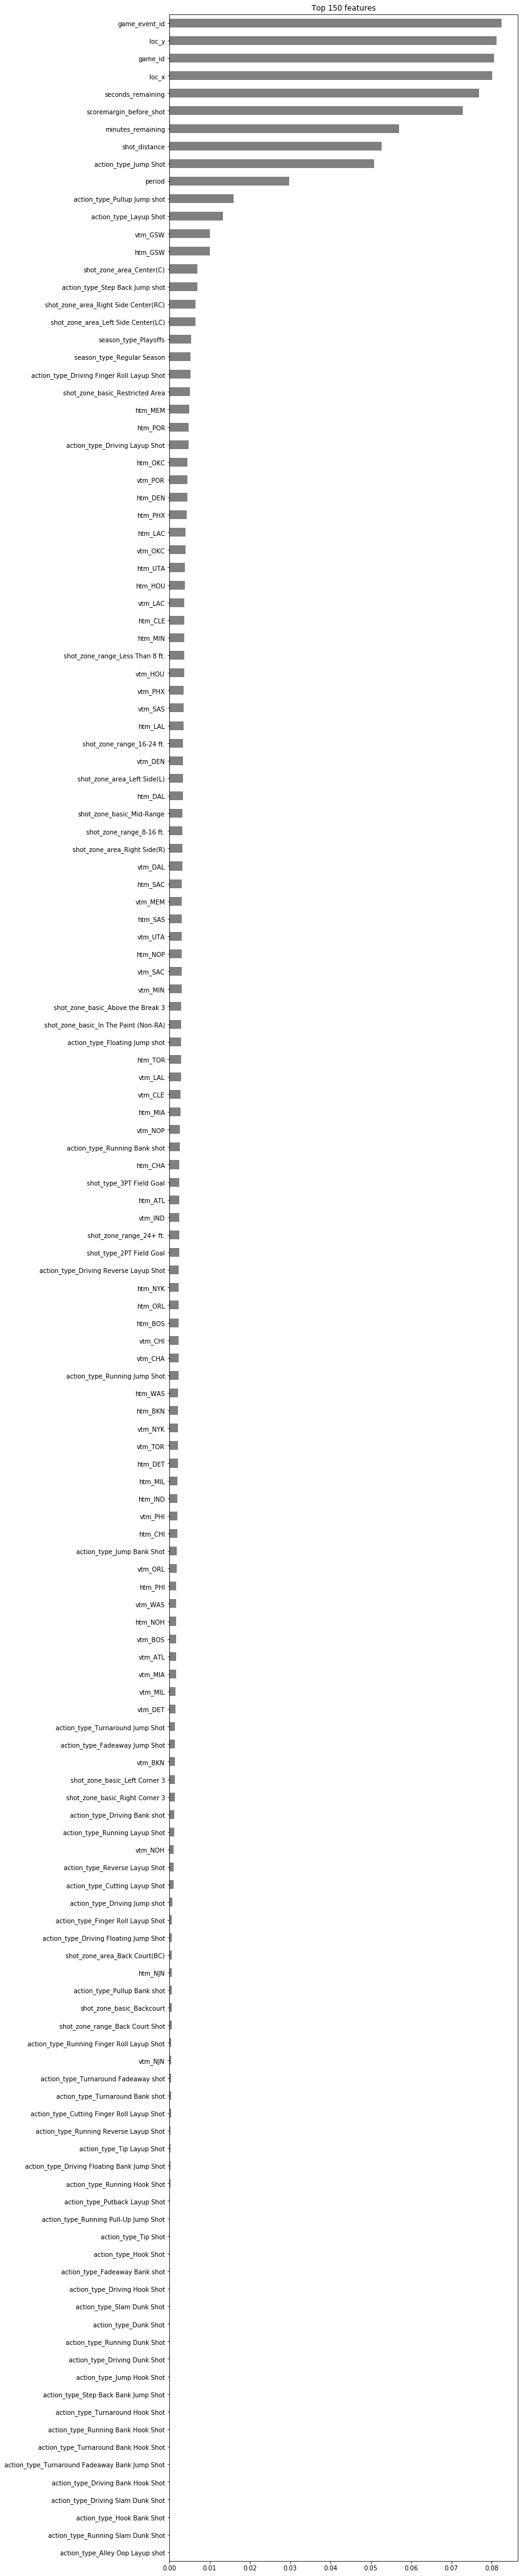

In [19]:
# Geting feature importances
rf = ohe_pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, xtrain_encoded.columns)

# Plot feature importances
n = 150
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');


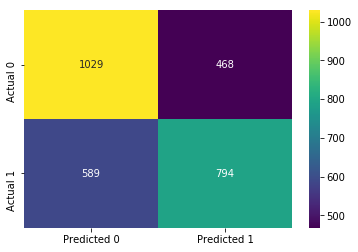

In [20]:
# Ploting confusioin matrix after training dataset with Random Forest. 
ypred = ohe_pipeline.predict(xval)

confusion_matrix(yval,ypred)
unique_labels(yval)

ohe_pipeline.named_steps['randomforestclassifier'].classes_

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}'  for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(yval, ypred); 

In [21]:
# Calculating accuracy
correct_pred = 1030 + 808
total_pred = 1030 + 467 + 575 + 808
print('Accuracy :',correct_pred / total_pred)


Accuracy : 0.6381944444444444


In [22]:
# Calculating percision
correct_pred_0 = 1030
total_pred_0 = 1030 + 575

print('precision for 0 :',correct_pred_0/total_pred_0)

precision for 0 : 0.6417445482866043


In [23]:
# Calculating recall
acutal_0 = 1030 + 467
print('recall for :',correct_pred_0/acutal_0 )

recall for : 0.6880427521710086


In [24]:
# Showing classification report for Random Forest model. 
print(classification_report(yval, ypred))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66      1497
           1       0.63      0.57      0.60      1383

   micro avg       0.63      0.63      0.63      2880
   macro avg       0.63      0.63      0.63      2880
weighted avg       0.63      0.63      0.63      2880



In [25]:
#Calculating Accuracy, precision, recall, and Fscore for confusion matric above


correct_pred = 36 + 85
total_pred = 36 + 85 + 58 + 8
print('Accuracy :',correct_pred / total_pred)

correct_pred_n = 85
total_pred_n = 85 + 8

print('precision for 0 :',correct_pred_0/total_pred_0)

acutal_n = 85 + 58
print('recall for :',correct_pred_0/acutal_0 )

precision = correct_pred_0/total_pred_0

recall = correct_pred_0/acutal_0

fscore = (2 * precision * recall) / (precision + recall)

print('Fscore :',fscore)

Accuracy : 0.6470588235294118
precision for 0 : 0.6417445482866043
recall for : 0.6880427521710086
Fscore : 0.664087685364281
